#EOSC 511
##Assignment OPTIONAL, Lab9 -Fast Fourier Transform
###Tereza Jarníková
###Student number: 81586142

2) Lowpass filter the Landsat scene so that fluctuations with spatial scales less than 1 km are removed from the image. (make plots of the filtered image and its 1-d power spectrum)

2) Answer

Strategy:

1)to get a visual idea, I first plotted the power spectrum using the ubc_fft class, which is fftshifted so that wavelengths with the highest power are in the middle. For the filter I will be keeping the power from some set of wavelengths and cutting out the rest. 

2) I look at the sorted kvals array (also produced by the ubc_fft class) to find out where the wavenumbers become greater than 1km (these are stored in inverse wavelength which is in units of (1/km))this is index 52.

3) I want to cut these out, so I write a short function that's called savesquare, that takes a square matrix with an even-numbered x dimension and cuts out a square of given size in the middle. In this square values are preserved, and everywhere else they're zero.

4) Then I take an fft of the optical depth, fftshift (to get high values in the middle), cut out the appropriate window, inverse fftshift, and inverse fft to get back an image that's smoothed so that variations at scales <1km are not visible. 
4a)Before I do that, I do the above method without the cutting out values to make sure that I can recover the original value. 

5) I plot the 1d power spectrum using the annular_avg function in a modified ubc_fft_dat class (which can take the array itself as input instead of taking a NetCDF file. The plot has tiny (order 1E-27) positive values for power for wavelengths >(1/km) . I assume that this is an artefact of the annular_avg function, which integrates power spectrum as a series of rings and then averages.

In [1]:
import numpy as np
# from numpy import numpy.fft as fft
from ubc_fft_class import ubc_fft
from ubc_fft_dat import ubc_fft_dat
from netCDF4 import Dataset
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from matplotlib import pyplot as plt
import urllib
import os
filelist=['a17.nc']
data_download=True
if data_download:
    for the_file in filelist:
        url='http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/{}'.format(the_file)
        urllib.request.urlretrieve(url,the_file)
with Dataset(filelist[0]) as nc:
    tau=nc.variables['tau'][...]

/Users/alena/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


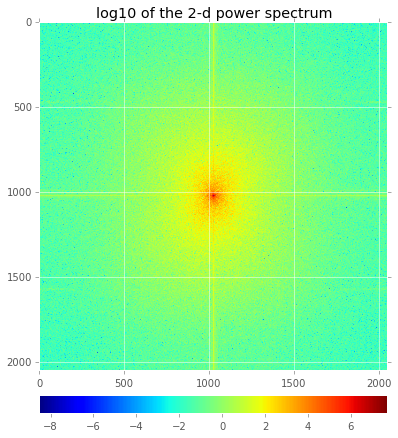

In [3]:
#plot power spectrum
plt.close('all')
plt.style.use('ggplot')
output = ubc_fft('a17.nc','tau',0.025)
output.power_spectrum()
fig,ax=plt.subplots(1,1,figsize=(7,7))
ax.set_title('landsat a17')
im0=ax.imshow((np.log10(output.spectral_dens)))
ax.set_title('log10 of the 2-d power spectrum')
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out=fig.colorbar(im0,orientation='horizontal',cax=cax)

1024
52
52
[ -0.00000000e+00   1.95312500e-02   3.90625000e-02 ...,   1.99414062e+01
   1.99609375e+01   1.99804688e+01]


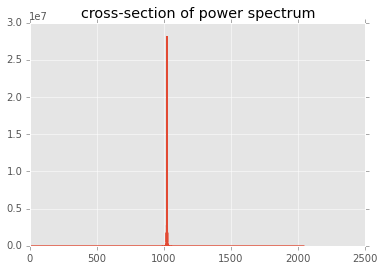

In [4]:
kvals = output.k_vals
print(kvals.size)
kvals = kvals*-1
kvals_sorted = np.sort(kvals)

for i in range(kvals.size):
    if (kvals_sorted[i]>1):
        bigger_than_1km =i 
        print(i)
        break

print(bigger_than_1km)
sp_dens = output.spectral_dens
spmid = (sp_dens[1024][:])
plt.plot(spmid)
plt.title('cross-section of power spectrum')
#spd_mid = sp_dens()
print(kvals_sorted)

In [5]:
def cutsquare(matrix,n,repval):
    """
           takes square array of even-valued length and height, 
           replaces (nxn) square in middle with repval
           (could make more genearal for non-even, non-square matrices)
    """
    
    size = matrix.shape
    size = size[1]
    halfsz = size/2
    center = halfsz -1
    halfcut = n/2
    #find out where to start cutting
    startsq = (int(center) - int(halfcut)+1)
    endsq = (int(center) + int(halfcut)+1)
    matrix[startsq:endsq,startsq:endsq]=repval
    
    return matrix

def savesquare(matrix,n):
    """
           takes square array of even-valued length and height, 
           makes array zero everywhere except for 
           (nxn) square in middle, where it's saved
           (could make more genearal for non-even, non-square matrices)
    """
    zeromat = np.zeros_like(matrix)
    
    size = matrix.shape
    size = size[1]
    halfsz = size/2
    center = halfsz -1
    halfcut = n/2
    #find out where to start cutting
    startsq = (int(center) - int(halfcut)+1)
    endsq = (int(center) + int(halfcut)+1)
    zeromat[startsq:endsq,startsq:endsq]=1
    new_matrix = np.multiply(zeromat,matrix)
    
    return new_matrix


/Users/alena/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


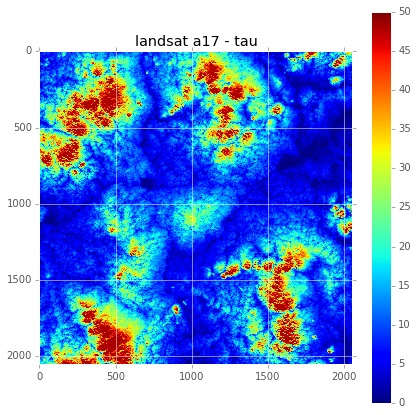

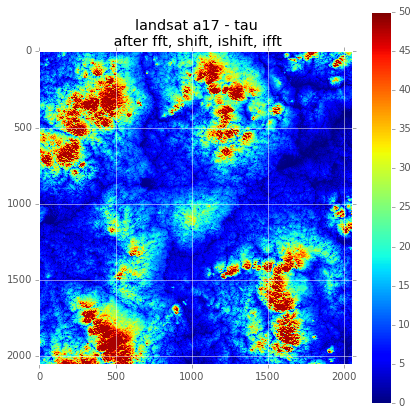

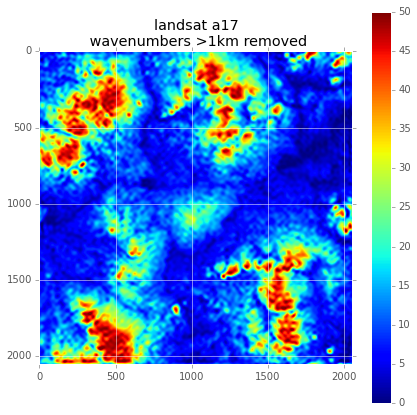

In [12]:
import numpy as np
fft_tau = np.fft.fft2(tau) 
fft_tau_shifted = np.fft.fftshift(fft_tau) 
inverseshift = np.fft.ifftshift(fft_tau_shifted)
back_to_normal = np.fft.ifft2(inverseshift)

fft_data = np.fft.fft2(tau)
fft_shift = np.fft.fftshift(fft_data)
fft_shift_cut = savesquare(fft_shift,104)
ifft_shift_back = np.fft.ifftshift(fft_shift_cut)
ifft_data_back= np.fft.ifft2(ifft_shift_back)
ifft_data_back_withim = ifft_data_back
ifft_data_back = np.real(ifft_data_back)

fig,ax=plt.subplots(1,1,figsize=(7,7))
ax.set_title('landsat a17 - tau')
im0=ax.imshow((tau))
divider = make_axes_locatable(ax)
fig.colorbar(im0, ax=ax)
im0.set_clim(0, 50.0)

fig,ax=plt.subplots(1,1,figsize=(7,7))
ax.set_title('landsat a17 - tau \n after fft, shift, ishift, ifft')
im0=ax.imshow(np.real(back_to_normal))
divider = make_axes_locatable(ax)
fig.colorbar(im0, ax=ax)
im0.set_clim(0, 50.0)

fig,ax=plt.subplots(1,1,figsize=(7,7))
ax.set_title('landsat a17')
im0=ax.imshow((ifft_data_back))
ax.set_title('landsat a17 \n wavenumbers >1km removed')
divider = make_axes_locatable(ax)
fig.colorbar(im0, ax=ax)
im0.set_clim(0, 50.0)

	- INTEGRATING... 
		row: 0 completed
		row: 100 completed
		row: 200 completed
		row: 300 completed
		row: 400 completed
		row: 500 completed
		row: 600 completed
		row: 700 completed
		row: 800 completed
		row: 900 completed
		row: 1000 completed
		row: 1100 completed
		row: 1200 completed
		row: 1300 completed
		row: 1400 completed
		row: 1500 completed
		row: 1600 completed
		row: 1700 completed
		row: 1800 completed
		row: 1900 completed
		row: 2000 completed


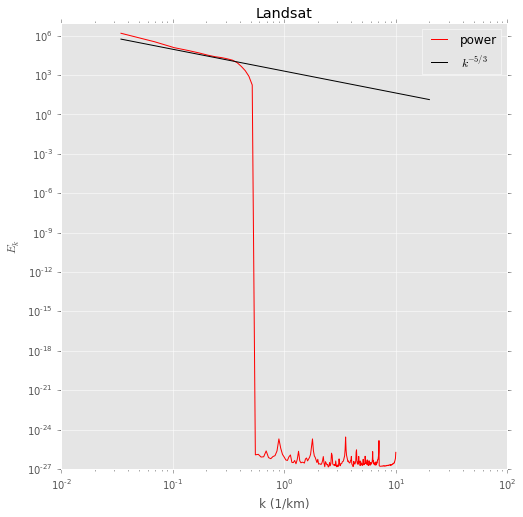

In [13]:
filtered = ifft_data_back_withim
output = ubc_fft_dat(filtered,0.025)
avg_binwidth=5  #make the kradial bins 5 pixels wide
output.power_spectrum()
output.annular_avg(avg_binwidth)
output.graph_spectrum(kol_offset=2000.,title='Landsat')